# XGBoost
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')

ModuleNotFoundError: No module named 'xgboost'

## normalize(df) function
This function needs to be ran on both testing and training data
It takes in a Pandas DataFrame and returns a DataFrame
```
How to use:
df = normalize(df)
```

In [2]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count


def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

### Normalize Train and Test data

In [3]:
train_df = normalize(train_df)
test_df = normalize(test_df)

### This is how the table looks now

In [21]:
pd.set_option('display.max_columns', None)
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,14000000,6.575393,93.0,12314651,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,24,3,1,2
1,40000000,8.248895,113.0,95149435,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,9,20,1,1,8
2,3300000,64.299990,105.0,13092000,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,64,51,3,1,10
3,1200000,3.174936,122.0,16000000,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,7,0,0,3
4,0,1.148070,118.0,3923970,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,4,0,0,2


### Adding average to budget values of 0

In [22]:
# var holding total budget
total_budget = 0
count = 0

# for loop traversing budget
for entry in train_df['budget']:
    total_budget += entry
    if entry != 0:
        count += 1
    
# finding average and adding it to entries with 0 value
budget_avg = total_budget / count
train_df.loc[train_df['budget'] == 0, 'budget'] = budget_avg
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,1.400000e+07,6.575393,93.0,12314651,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,24,3,1,2
1,4.000000e+07,8.248895,113.0,95149435,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,9,20,1,1,8
2,3.300000e+06,64.299990,105.0,13092000,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,64,51,3,1,10
3,1.200000e+06,3.174936,122.0,16000000,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,7,0,0,3
4,3.089305e+07,1.148070,118.0,3923970,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,4,0,0,2


## Starting XGBoost Algorithm

In [4]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# split data
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

# scale feature data
X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check size of sets
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2400, 31)
(600, 31)
(2400,)
(600,)


In [7]:
# import tools
from sklearn.model_selection import GridSearchCV

# dictionary with parameters to test
params = {'n_estimators': [100, 200, 500, 750, 1000],
              'max_depth': [5, 6, 7, 8],
              'eta': [0.01, 0.02, 0.05],
              'subsample': [0.6, 0.7, 0.8, 1.0],
              'colsample_bytree': [0.8, 1.0]}

# create regressor
xgb_reg = XGBRegressor(random_state=2)

# create grid
xgb_grid = GridSearchCV(xgb_reg,
                        params,
                        cv = 10,
                        scoring='neg_mean_squared_error',
                        verbose=True)

# fit the grid
xgb_grid.fit(X_train, y_train)

# see results
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
-5928874931809020.0
{'colsample_bytree': 1.0, 'eta': 0.02, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [7]:
# import tools
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# using best params
xgb_best = XGBRegressor(n_estimators=200, max_depth=7, eta=0.02, subsample=0.7, colsample_bytree=1.0)
xgb_best.fit(X_train, y_train)
y_predict_xgb = xgb_best.predict(X_test)

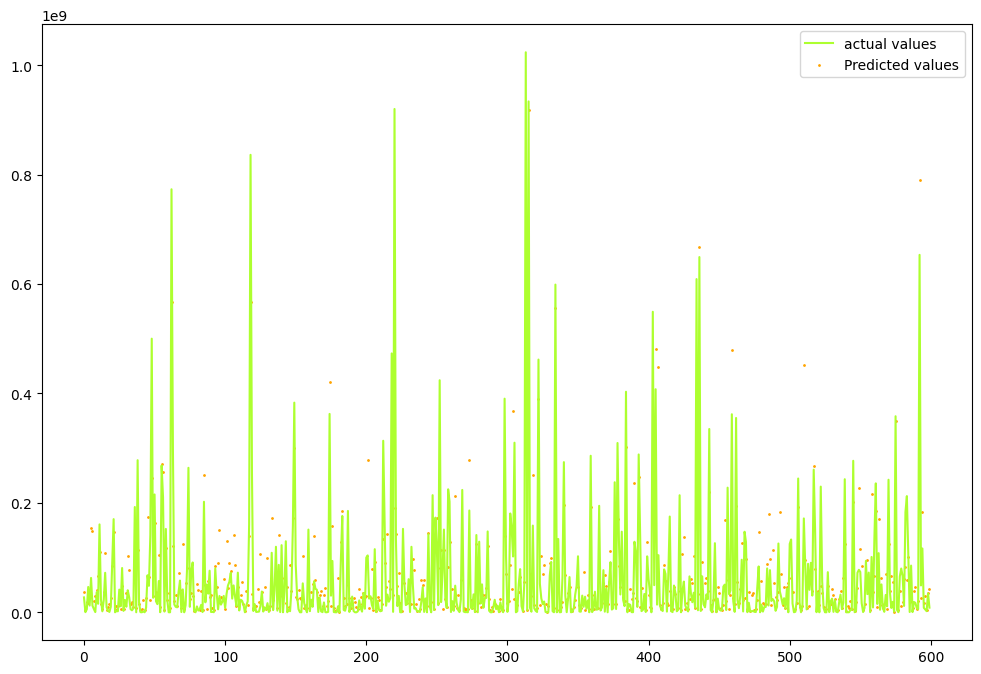

r2_score: 0.6529895847965537 
RMSE: 72900026.99178609


In [8]:
plt.figure(figsize=(12, 8))

# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.scatter([i for i in range(len(y_test))],y_predict_xgb, label="Predicted values", c='orange', s=1)

plt.legend()
plt.show()

mse = metrics.mean_squared_error(y_test, y_predict_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_predict_xgb)
print( f"r2_score: {r2} \nRMSE: {rmse}")

R2 : 0.6414799950655874 
RMSE: 74099133.76498169


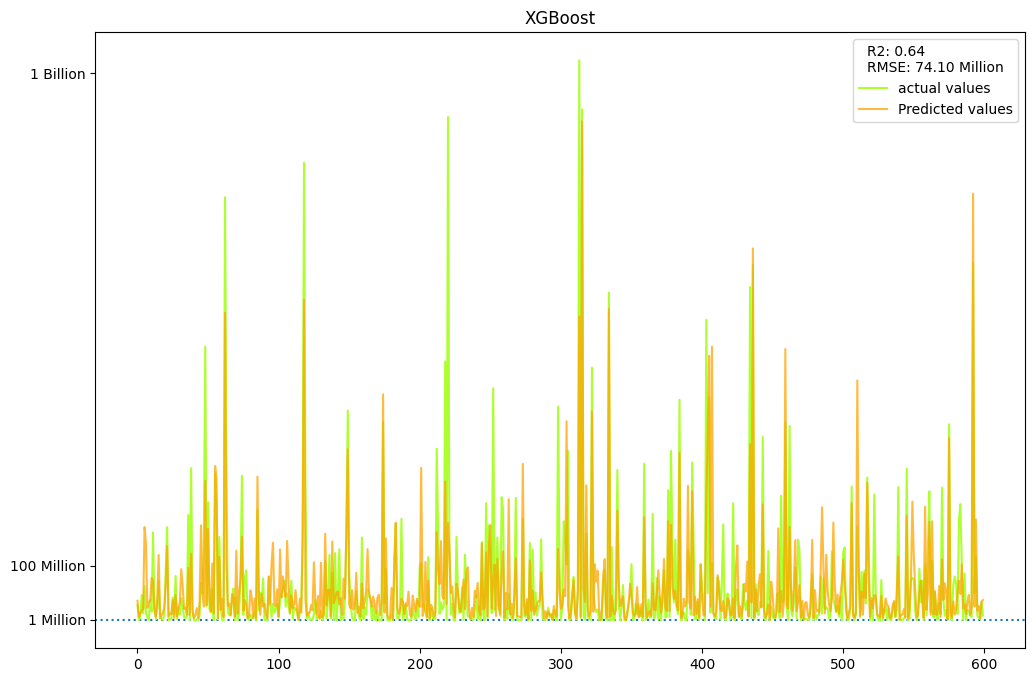

In [17]:
plt.figure(figsize=(12, 8))
plt.title("XGBoost")
plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])
# Draw line for 0 values
plt.axhline(y=0, linestyle='dotted')
# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.plot([i for i in range(len(y_test))],y_predict_xgb, label="Predicted values", c='orange',alpha=0.75,zorder=10)



mse = metrics.mean_squared_error(y_test, y_predict_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_predict_xgb)
print( f"R2 : {r2} \nRMSE: {rmse}")
plt.legend(title=f"R2: {r2:.2f}\nRMSE: {(rmse/1000000):.2f} Million")
plt.show()

## Test Model over different train test splits

In [9]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data
train_df = pd.read_csv('../Source/train.csv')
train_df = normalize(train_df)
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

r2_average = 0;
rmse_average = 0;
number_of_loops = 100

for j in range(0,number_of_loops):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_loop = sc_X.fit_transform(X)
    y_loop = sc_y.fit_transform(pd.DataFrame(y))
    X_train, X_test, y_train, y_test = train_test_split(X_loop, y_loop, test_size=.10, random_state=j)
    
    RF_best = XGBRegressor(n_estimators=200, max_depth=7, eta=0.02, subsample=0.7, colsample_bytree=1.0)
    RF_best.fit(X_train, y_train.ravel())
    y_pred = RF_best.predict(X_test)    
    
    #  fitting the size of the plot
    #plt.figure(figsize=(12, 8))
    #plt.title(f"ADABoost\nRandom State {j}")
    #plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])


    y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred)) 
    y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 

    # Draw line for 0 values
    #plt.axhline(y=0, linestyle='dotted')

    # plotting the graph for the actual values
    #plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

    # plotting the graph for predictions
    #plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', alpha=0.75)#, s=5)

    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    r2_average += r2
    rmse_average += rmse
    print( f"R2: {r2} RMSE: {rmse/1000000}\n j = {j}")
    #plt.legend(title=f"r2_score:  {r2:.3f}\nRMSE:  {rmse/1000000:.2f} million")
    #plt.savefig(f"./Plots/ADA_Boost_{j}.png")
print(f"\n R2 average: {r2_average/number_of_loops}\n RMSE Average: {(rmse_average/number_of_loops)/1000000}")

#plt.show()


R2: 0.6685357516699173 RMSE: 86.21673841811429
 j = 0
R2: 0.5241023280417405 RMSE: 85.26794390019442
 j = 1
R2: 0.5722655053879045 RMSE: 74.52126468708522
 j = 2
R2: 0.6664938749023528 RMSE: 75.43900461799961
 j = 3
R2: 0.6341520565327319 RMSE: 81.45091257258288
 j = 4
R2: 0.5997258224079884 RMSE: 61.36089556387308
 j = 5
R2: 0.5987636650252355 RMSE: 107.46507564651247
 j = 6
R2: 0.597959552483647 RMSE: 95.17934357687902
 j = 7
R2: 0.6120325199658292 RMSE: 85.27378291570172
 j = 8
R2: 0.7573890787770164 RMSE: 58.45948359677074
 j = 9
R2: 0.7243628994881961 RMSE: 75.85875932462527
 j = 10
R2: 0.6007184251596527 RMSE: 82.17207617395835
 j = 11
R2: 0.7221027074689292 RMSE: 62.31413759037854
 j = 12
R2: 0.39335242025256023 RMSE: 81.2510896124757
 j = 13
R2: 0.6487926167792106 RMSE: 91.44485096408982
 j = 14
R2: 0.689172070176659 RMSE: 80.61941699514406
 j = 15
R2: 0.6395375623716214 RMSE: 99.05113178451676
 j = 16
R2: 0.6042641219230948 RMSE: 93.58697105480415
 j = 17
R2: 0.662389330413715